This is a notebook to recreate Figure 8 of [Lamb, Taylor & van Haasteren 2023](https://arxiv.org/abs/2303.15442).  This notebook calculates the effective number of pulsars

In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import numpy as np
import matplotlib.pyplot as plt
import glob
from chainconsumer import ChainConsumer
import pickle
from ceffyl import Ceffyl, models
from enterprise.signals import parameter, gp_priors as gpp
from enterprise_extensions.model_utils import get_tspan
from natsort import natsorted
import la_forge.core as co
from la_forge.slices import SlicesCore

# ACCRE-specific import to load correct latex file
## COMMENT OUT AS REQUIRED
import os
os.environ["PATH"] += os.pathsep + '/home/lambwg/latex/bin/x86_64-linux' 

In [2]:
# setup default plotting code
plt.rcParams.update(plt.rcParamsDefault)
with open('/home/lambwg/ng15_rcparams.json', 'rb') as fin:
    plt.rcParams.update(json.load(fin))

In [200]:
plt.rcParams["figure.figsize"] = [3.5503666805036667, 2.1942472810764047]

In [201]:
from astroML.stats import sigmaG  # rank-reduced uncertainty

# What is the effective number of pulsars in a simulated data set?

Use GFL Lite single pulsar free spectra

In [202]:
# labels for log10rho
rho_labels = [f'log10_rho_{ii}' for ii in range(10)]

Tspan = 477171786.6242733  # obs timespan
df = 1/Tspan

psrs are indexed alphabetically. Change to longest to shortest tspans

In [239]:
# shortest to longest tspans
psridx = np.array([41, 13,  7,  9, 36, 40, 30, 42, 14, 25, 10, 35, 43, 24,  5, 39, 32,
                   3, 37, 22,  2, 26,  8, 21, 27, 12, 34, 29, 17, 33, 16,  6, 18,  4,
                   20, 44,  0, 28, 19, 31,  1, 38, 11, 23, 15])[::-1]

load GFL Lite $\log_{10}\rho$ posteriors

In [159]:
# load log10rho posteriors for all pulsars
rho10 = np.array([co.Core(corepath=f'/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_51/psr_{ii}/chain.core')(rho_labels)
                  for ii in range(45)])

In [160]:
rho10.shape

(45, 374925, 10)

taking sigmaG on log10rho

In [161]:
sigmarho = sigmaG(rho10, axis=1)

taking the inverse squared sum and cumulatively add across frequencies (if we want investigate $N_\mathrm{eff}$ for various $N_f$)

In [162]:
inv_Srho2 = 1/sigmarho**2
sum_over_f = np.cumsum(inv_Srho2, axis=1)

In [244]:
# calculate Neff as a function of Np for Nf=10
Nf = 10

Nf_idx = Nf - 1  # correct for python indexing
idx = np.argsort(sum_over_f[:, Nf_idx])[::-1]
Neff_p = np.zeros(45)
for ii in range(1, 46):
    n = sum_over_f[idx[:ii], Nf_idx]
    Neff_p[ii-1] = n.sum()/n.max()

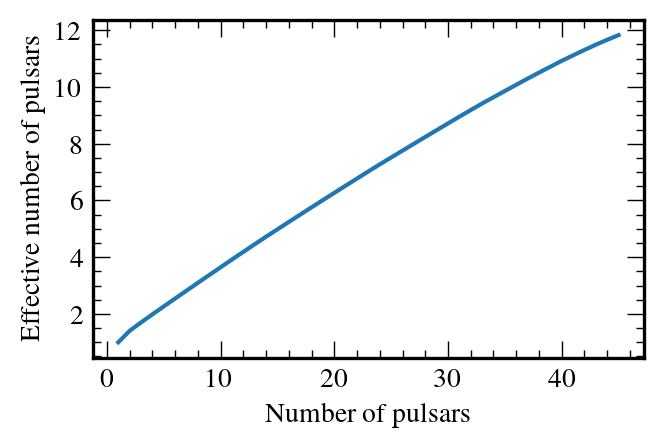

In [245]:
plt.plot(np.arange(1, 46), Neff_p)
plt.xlabel('Number of pulsars')
plt.ylabel('Effective number of pulsars')
plt.show();

##### Finding uncertainties on the posterior

Taking the same chain samples as used in Figures 6 & 7. Here, we must use GFL Lite single pulsars as we're adding frequencies/pulsars

In [268]:
# load paths to files of chains from GFL LITE per number of PULSARS
datadir = '/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_51/fftkde_10000_final/refits/m2aNpsr_down//'

params2 = [f'{ii}psr' for ii in range(1, 46)]  # create labels for chains

# use la_forge's SlicesCore class to only load log10_A and gamma
downA = SlicesCore(slicedirs=[datadir+f'/{ii}psr/' for ii in range(1, 46)],
                   params=params2, pars2pull=['log10_A_gw'])
downg = SlicesCore(slicedirs=[datadir+f'/{ii}psr/' for ii in range(1, 46)],
                   params=params2, pars2pull=['gamma_gw'])

/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_51/fftkde_10000_final/refits/m2aNpsr_down///45psr//chain_1.txt is loaded.

/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_51/fftkde_10000_final/refits/m2aNpsr_down///45psr//chain_1.txt is loaded.



In [269]:
# take sigmaG of these chains
std_log10A_npsr = sigmaG(downA(params2), axis=0)
std_gamma_npsr = sigmaG(downg(params2), axis=0)

## PLOT!

plot them together!

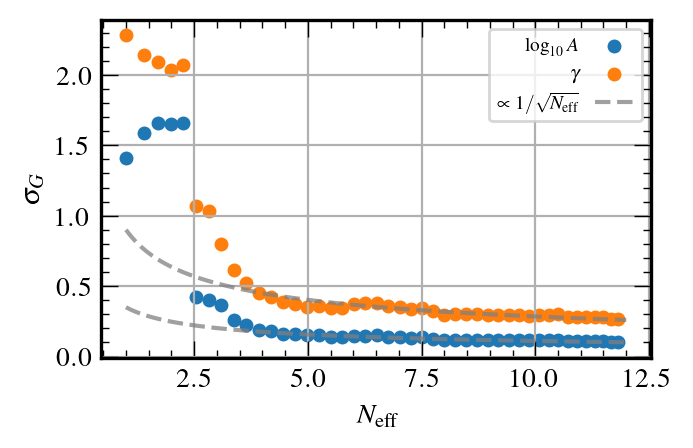

In [277]:
fig, ax2 = plt.subplots(ncols=1, sharey=True)

p = np.linspace(1, 12., 100)

ax2.scatter(Neff_p, std_log10A_npsr,
            label='$\log_{10}A$')
ax2.scatter(Neff_p, std_gamma_npsr,
            label='$\gamma$')

ax2.plot(p, 0.9/np.sqrt(p), c='grey', ls='--', alpha=0.75,
         label='$\propto 1/\sqrt{N_\mathrm{eff}}$')
ax2.plot(p, 0.35/np.sqrt(p), c='grey', ls='--', alpha=0.75)

#plt.xticks(np.arange(2,16,2))

ax2.set_xlabel(r'$N_\mathrm{eff}$')
ax2.set_ylabel('$\sigma_G$')
ax2.legend(markerfirst=False); ax2.grid(True)
#ax2.set_ylim(0,1)

fig.savefig('../plots/neff.pdf',
            dpi=400, bbox_inches="tight")
plt.show();

# Apply to 12.5 yr data set!

In [223]:
# organising psrs from LONGEST to SHORTEST tspan
psridx = np.array([23, 15, 11,  1, 38, 28, 31, 19, 44,  0, 20,  4, 18,  6, 16, 33, 17,
                   29, 34, 12, 21, 27,  8, 26,  3, 37, 22,  2, 32, 39, 24,  5, 43, 35,
                   10, 25, 42, 40, 30, 14, 36, 13,  9,  7, 41])

In [224]:
psridx.shape

(45,)

In [225]:
# load parameter labels
rho_labels = [f'gw_crn_log10_rho_{ii}' for ii in range(30)]
Tspan_125 = 407576851.48121357
df_125 = 1/Tspan_125

In [6]:
# load log10rho posteriors
gfllite_chains = natsorted(glob.glob(f'/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/psr_*/chain.core'))
chains = np.array([co.Core(corepath=c)(rho_labels) for c in gfllite_chains])

min_shape = min(c.shape[0] for c in chains)
rho30 = np.dstack([c[-500000:] for c in chains]).T

/tmp/ipykernel_12231/1793979112.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chains = np.array([co.Core(corepath=c)(rho_labels) for c in gfllite_chains])


In [7]:
# taking sigmaG of the posteriors
mu_Sf_125 = sigmaG(rho30, axis=2)

In [146]:
# cumulative sum over frequencies
sum_over_f_125 = np.cumsum(1/mu_Sf_125**2, axis=1)
sum_over_f_125.shape

(45, 30)

In [226]:
# calculating Neff as a function of Np for 5 freqs\
Nf = 5

Nf_idx = Nf - 1  # correct for python indexing
Neff_p_125 = np.zeros(45)

# index from greatest to smallest value of sum over freqs
idx = np.argsort(sum_over_f_125[:, Nf_idx], axis=0)[::-1]
for ii in range(1, 46):
    n = sum_over_f_125[idx[:ii], Nf_idx]
    Neff_p_125[ii-1] = np.sum(n)/n.max()

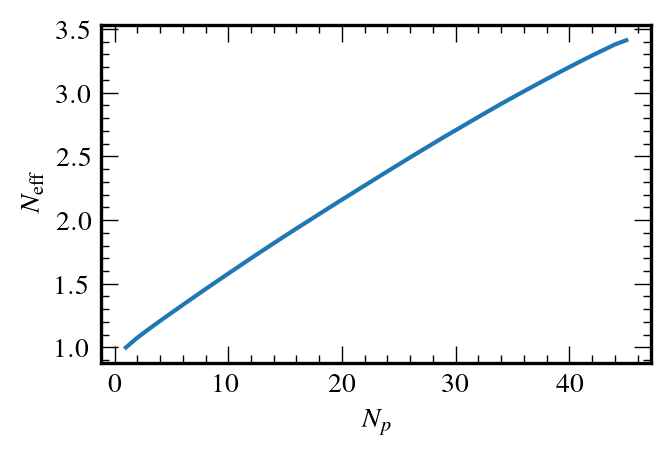

In [228]:
plt.plot(np.arange(1,46), Neff_p_125)
#plt.plot(np.arange(1,44), Neff_p_125_2)

plt.xlabel(r'$N_p$')
plt.ylabel(r'$N_\mathrm{eff}$')
plt.show();

##### load per psr analyses

In [35]:
# load paths to files of chains from GFL LITE per number of FREQUENCIES
chains = [f'/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/densities/refits/m2aperfreq_v2/{ii}f/'
          for ii in range(1,31)]

params = [f'{ii}f' for ii in range(1,31)]  # label chains

# use la_forge's SlicesCore class to only load log10_A and gamma
log10A_gl_125 = SlicesCore(slicedirs=chains, pars2pull='log10_A_gw',
                           params=params)
gamma_gl_125 = SlicesCore(slicedirs=chains, pars2pull='gamma_gw',
                          params=params)

/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/densities/refits/m2aperfreq_v2/30f//chain_1.txt is loaded.



In [229]:
# load paths to files of chains from GFL LITE per number of PULSARS
datadir = '/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/densities/refits/m2aNpsr_down_best/'
params2 = [f'{ii}psr' for ii in range(1, 46)]  # param labels

downA_125 = SlicesCore(slicedirs=[datadir+f'/{ii}psr' for ii in range(1, 46)],
                       params=params2, pars2pull=['log10_A_gw'])
downg_125 = SlicesCore(slicedirs=[datadir+f'/{ii}psr' for ii in range(1, 46)],
                       params=params2, pars2pull=['gamma_gw'])

/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/densities/refits/m2aNpsr_down_best//45psr/chain_1.txt is loaded.

/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/densities/refits/m2aNpsr_down_best//45psr/chain_1.txt is loaded.



In [230]:
# take sigmaG of these chains
std_log10A_npsr_125 = sigmaG(downA_125(params2), axis=0)
std_gamma_npsr_125 = sigmaG(downg_125(params2), axis=0)

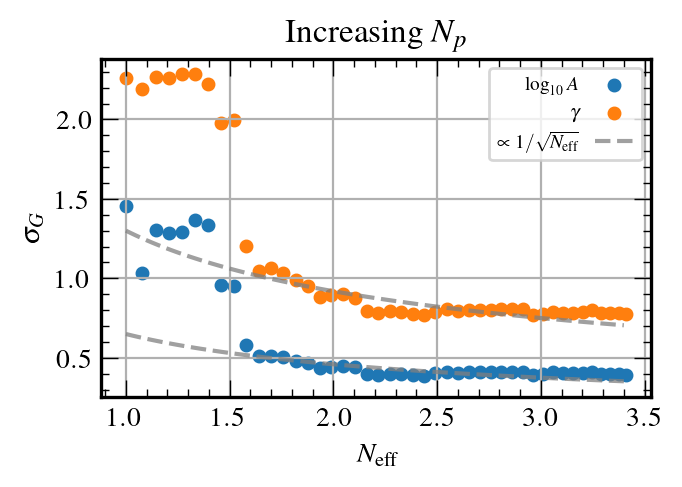

In [281]:
fig, ax2 = plt.subplots(ncols=1, sharey=False)

# -----------------------------
p = np.linspace(1, 3.4, 100)

ax2.scatter(Neff_p_125, std_log10A_npsr_125,
            label='$\log_{10}A$')
ax2.scatter(Neff_p_125, std_gamma_npsr_125,
            label='$\gamma$')

ax2.plot(p, 0.65/np.sqrt(p), c='grey', ls='--', alpha=0.75,
         label='$\propto 1/\sqrt{N_\mathrm{eff}}$')
ax2.plot(p, 1.3/np.sqrt(p), c='grey', ls='--', alpha=0.75)

#plt.xticks(np.arange(2,16,2))

ax2.set_xlabel(r'$N_\mathrm{eff}$')
ax2.set_title(r'Increasing $N_p$')
ax2.set_ylabel('$\sigma_G$')
ax2.legend(markerfirst=False); ax2.grid(True)
#ax2.set_ylim(0.25,1.5)

fig.savefig('../plots/neff_125.pdf',
            dpi=400, bbox_inches="tight")
plt.show();